# Glass Bangle Defect Detection(이진 분류)

### 데이터 준비 : 드라이브 마운트 및 데이터 분리

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')


# 파일을 불러오기 위한 모듈
import os

In [2]:
# 파일이 있는 경로로 이동
%cd "/content/drive/MyDrive/deeplearning_project_ZB7"

# 경로 확인
os.getcwd()

'c:\\Users\\theo\\Documents\\deep_learning\\dl-project'

In [3]:
# 파일 확인
os.listdir()

['cnn_glass_bangle_defect_detection_epoch_15_with_adam_relu.h5',
 'cnn_glass_bangle_defect_detection_epoch_30_with_adam_swish.h5',
 'dataset',
 'image_classification_deeplearning_theo.ipynb',
 'image_classification_model.h5',
 'split_data',
 'theo_modified_colab_ver.ipynb']

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# 파일 나누기
import splitfolders

original_dir = 'dataset'
classes_list = os.listdir(original_dir)

base_dir = './split_data'
os.mkdir(base_dir)
splitfolders.ratio(original_dir, output=base_dir, seed = 35, ratio=(.8,.1,.1))

In [5]:
# 원본 파일 확인
print('original/good :', len(os.listdir('dataset/good')))
print('original/broken :',len(os.listdir('dataset/broken')))

original/good : 520
original/broken : 560


In [6]:
# train, validation, test로 나눠진 파일들 확인
print('train/good :', len(os.listdir('split_data/train/good')))
print('train/broken :',len(os.listdir('split_data/train/broken')))
print('val/good :',len(os.listdir('split_data/val/good')))
print('val/broken :',len(os.listdir('split_data/val/broken')))
print('test/good :',len(os.listdir('split_data/test/good')))
print('test/broken :',len(os.listdir('split_data/test/broken')))

train/good : 416
train/broken : 448
val/good : 52
val/broken : 56
test/good : 52
test/broken : 56


### 데이터 준비 : 훈련 및 검증 데이터 경로 지정


In [7]:
# 경로 설정
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

### 데이터 준비 : 이미지 데이터 전처리

In [8]:
# CUDA 적용 : 속도 이슈 해결
import torch

USE_CUDA = torch.cuda.is_available()
Device = torch.device('cuda' if USE_CUDA else 'cpu')

print(Device)

cuda


In [9]:
# 이미지 텐서화 작업
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform_base = transforms.Compose([transforms.Resize((150,150)), transforms.ToTensor()])

train_dataset = ImageFolder(root='./split_data/train', transform=transform_base)
val_dataset = ImageFolder(root='./split_data/val', transform=transform_base)

In [10]:
# 이미지 데이터 최종 전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 864 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


## 모델 구성

In [ ]:
# 모델 구성하기 : CNN
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

In [ ]:
# 모델 컴파일하기
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
# 모델 훈련하기
hist = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=15,
                    epochs=40,
                    validation_steps=5,
                    verbose=2)

In [ ]:
# 모델 저장하기

model.save('best_model_binary.h5')

## 모델 준비 완료 --> saliency 적용

In [21]:
from keras.models import load_model

# 모델 불러오기
model = load_model('best_model_binary.h5')

In [22]:
# 테스트 데이터 전처리
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 16,
                                                  class_mode  = 'binary',
                                                  target_size = (150, 150))

Found 108 images belonging to 2 classes.


In [60]:
!pip install saliency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 KB 3.0 MB/s eta 0:00:00


#### Saliency 모델의 output과 input 사이의 gradient 연산 처리

In [23]:
import saliency.core as saliency
import tensorflow as tf
import numpy as np

def model_fn(images, call_model_args, expected_keys=None):
   
    target_class_idx = call_model_args['class']
    model = call_model_args['model']
    images = tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output = model(images)
            output = output[:,target_class_idx]
            gradients = np.array(tape.gradient(output, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv, output = model(images)
            gradients = np.array(tape.gradient(output, conv))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

####   Saliency map을 이용하여 기여도 맵 추출 함수

In [24]:
def vanilla_saliency(model, img):
    """
    :model: 학습된 인공지능 모델
            인공지능 모델이 바뀔 때, 기여도 맵 또한 변경됨.
    :img:   기여도 맵을 추출하고 하는 이미지 데이터
    :return: 추출된 기여도 맵

    """
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    grad = saliency.GradientSaliency()
    attr = grad.GetMask(img, model_fn, args)
    attr = saliency.VisualizeImageGrayscale(attr)
    
    return tf.reshape(attr, (*attr.shape, 1))

def ig(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    ig = saliency.IntegratedGradients()
    attr = ig.GetMask(img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)
    attr = saliency.VisualizeImageGrayscale(attr)

    return tf.reshape(attr, (*attr.shape, 1))

def smooth_saliency(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    smooth_grad = saliency.GradientSaliency()
    smooth_attr = smooth_grad.GetSmoothedMask(img, model_fn, args)
    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

def smooth_ig(model, img):

    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    smooth_ig = saliency.IntegratedGradients()

    smooth_attr = smooth_ig.GetSmoothedMask(
        img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)

    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

#### sample data 시각화: 분류 라벨별('good' or 'broken')
- next를 통해서 iterator에서 batch 하나를 뽑기

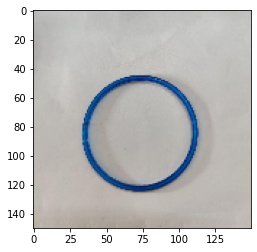

In [37]:
# sample 이미지를 하나 뽑기 : 첫번째 것은 정상 이미지

import matplotlib.pyplot as plt

plt.imshow(x_val[1])

In [38]:
# 여기서 적용되는 모델은 swish와 epoch=30 을 적용한 모델

sample_image = x_val[1]
sample_saliency_xai_image = vanilla_saliency(model, x_val[1])
sample_ig_xai_image = ig(model, x_val[1])

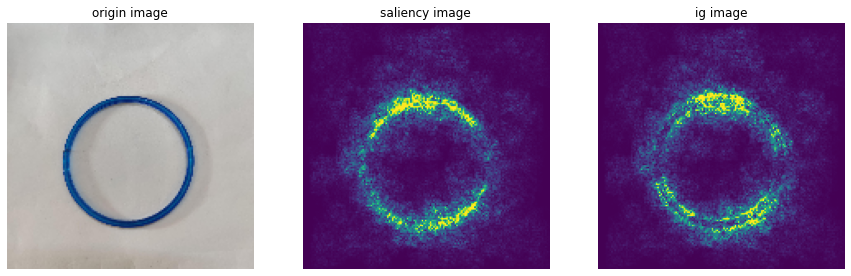

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.reshape(sample_image, (150, 150, 3)))
plt.title("origin image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(sample_saliency_xai_image, (150, 150)))
plt.title("saliency image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(sample_ig_xai_image, (150, 150)))
plt.title("ig image")
plt.axis('off')

plt.show()

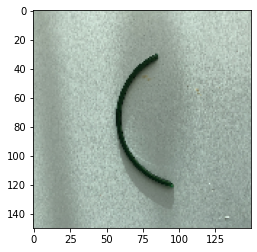

In [41]:
# sample 이미지를 하나 뽑아보자 : 두번째 것은 비정상 이미지

plt.imshow(x_val[4])

In [42]:
sample_image = x_val[4]
sample_saliency_xai_image = vanilla_saliency(model, x_val[4])
sample_ig_xai_image = ig(model, x_val[4])

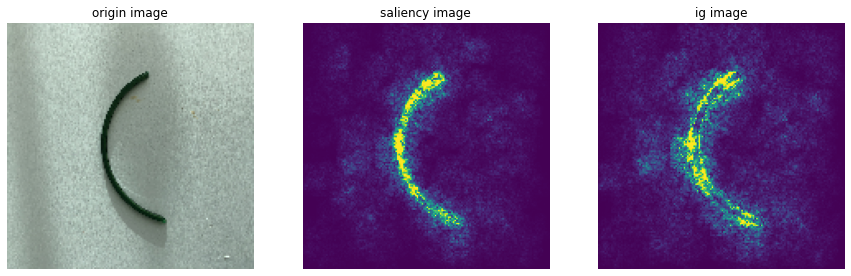

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.reshape(sample_image, (150, 150, 3)))
plt.title("origin image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(sample_saliency_xai_image, (150, 150)))
plt.title("saliency image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(sample_ig_xai_image, (150, 150)))
plt.title("ig image")
plt.axis('off')

plt.show()

## XAI형태로 데이터 추출

- 1. validation_generator, train_generator 안에 있는 모든 데이터들을 이어서 학습
- 2. 모든 데이터를 잇는 방식은 batch로 처리하는 방식에 비해서 속도 측면에서 비효율적
- 3. 따라서 모델을 상정하고 generator에서 batch를 반복적으로 추출
- 4. 각각의 batch를 차례대로 ig 처리해서 model에 순차적으로 학습

In [62]:
# 두 데이터 모두 batch size를 100개로 다시 전처리

train_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=100,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  train_datagen.flow_from_directory(val_dir,
                                                       batch_size=100,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

test_generator =  train_datagen.flow_from_directory(test_dir,
                                                       batch_size=100,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 864 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [65]:
iterators_1 = iter(train_generator)
iterators_2 = iter(validation_generator)
iterators_3 = iter(test_generator)

cnt = 0
while True:
  x, y = next(iterators_1)
  z = len(x)
  cnt += 1
  if cnt == 1:
    X_train = x
    y_train = y
  else:
    X_train = np.concatenate((X_train, x), axis=0)
    y_train = np.concatenate((y_train, y), axis=0)
  if z == 64:
    break
while True:
  x, y = next(iterators_2)
  z = len(x)
  X_train = np.concatenate((X_train, x), axis=0)
  y_train = np.concatenate((y_train, y), axis=0)
  if z == 8:
    break
cnt = 0
while True:
  x, y = next(iterators_3)
  z = len(x)
  cnt += 1
  if cnt == 1:
    X_val = x
    y_val = y
  else:
    X_val = np.concatenate((X_val, x), axis=0)
    y_val = np.concatenate((y_val, y), axis=0)
  if z == 8:
    break
ig_x_train = np.zeros_like(X_train)
ig_x_test = np.zeros_like(X_val)

for i in range(len(ig_x_train)):
    ig_x_train[i] = ig(model, X_train[i])

for i in range(len(ig_x_test)):
    ig_x_test[i] = ig(model, X_val[i])

#### XAI 추출 데이터 모델 생성

In [71]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

new_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

new_model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics = ['accuracy'])

new_model.fit(ig_x_train, y_train, epochs=5, shuffle=True)

Epoch 1/5
31/31 [==============================] - 5s 119ms/step - loss: 0.7363 - accuracy: 0.5329
Epoch 2/5
31/31 [==============================] - 4s 118ms/step - loss: 0.6488 - accuracy: 0.6512
Epoch 3/5
31/31 [==============================] - 4s 119ms/step - loss: 0.5410 - accuracy: 0.7263
Epoch 4/5
31/31 [==============================] - 4s 119ms/step - loss: 0.4094 - accuracy: 0.8158
Epoch 5/5
31/31 [==============================] - 4s 119ms/step - loss: 0.3806 - accuracy: 0.8230


#### 예측이 틀린 데이터 추출

In [72]:
# x, y = next(iter(test_generator)) # next를 실행하면 다시 shuffle 됨
print(X_val[0].shape,len(X_val))

predictions = new_model.predict(X_val)
predictions = np.round(predictions).astype('int')

pred_vec=[]
for i in predictions:
  pred_vec.append(i[0])

pred_vec=np.array(pred_vec)

# 틀린 데이터의 인덱스 도출
incorrect_idx = np.where(pred_vec != y_val)[0]
print('예측 틀린 데이터 수 : ',len(incorrect_idx))

(150, 150, 3) 108
예측 틀린 데이터 수 :  54


In [ ]:
# 틀린 데이터 이미지와 레이블을 가지고 오기

incorrect_images = []
incorrect_labels = []

for i in incorrect_idx:
    incorrect_images.append(x[i])
    incorrect_labels.append(y[i])

incorrect_images = np.array(incorrect_images)
incorrect_labels = np.array(incorrect_labels)

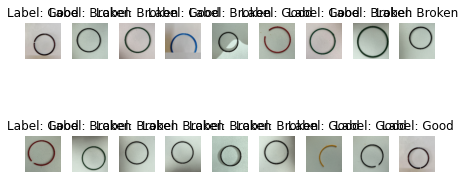

In [ ]:
# 틀린 데이터 이미지 조회

for i, (img, label) in enumerate(zip(incorrect_images, incorrect_labels)):
    plt.subplot(2, 9, i + 1)
    plt.imshow(img)
    plt.axis("off")
    if label == 1:
        plt.title("Label: Broken")
    else:
        plt.title("Label: Good")

plt.tight_layout()
plt.show()